In [5]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [6]:
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from scipy.stats.mstats import gmean

In [492]:
rf_rates = dl.pull('RFrates').divide(100)
daily_rf_rates = (rf_rates + 1).pow(1/261)-1
daily_rf_rates = daily_rf_rates.resample('B').ffill()

monthly_rf_rates = (rf_rates + 1).pow(1/12)-1

rf_rate_matrix = pd.DataFrame(0, index=bond_return_index.index, 
                              columns=bond_return_index.columns)
rf_rate_matrix_monthly = pd.DataFrame(0, index=monthly_rf_rates.index, 
                              columns=bond_return_index.columns)
for country in country_codes:
    rf_rate_matrix[country] = daily_rf_rates
    rf_rate_matrix_monthly[country] = monthly_rf_rates

# Helper Functions

**Profit and Loss Curve Function**

In [603]:
def pnl_curve(signals):
    daily_signals = signals.resample("B").ffill()
    
    bond_daily_returns = bond_return_index.pct_change() - rf_rate_matrix
    lagged_returns = bond_daily_returns.shift(-1)

    sig_returns = (lagged_returns * daily_signals)
    cum_sig_returns = (1+sig_returns).cumprod()
    sig_pct = (cum_sig_returns-1)*100
    
    for country in country_codes:
        sig_pct[country].rolling(60).mean().plot()
        plt.title(country + ' Returns')
        plt.ylabel('Return Percentage (%)')
        plt.show()
    
    sig_pct.sum(axis=1).plot()
    plt.title('Total Returns')
    plt.ylabel('Return Percentage (%)')
    plt.show()

**Sharpe Ratio Function**

In [296]:
def sharpe_ratio(signals):
    
    daily_signals = signals.resample("B").ffill()
    
    bond_daily_returns = bond_return_index.pct_change() - rf_rate_matrix 
    lagged_returns = bond_daily_returns.shift(-1)

    returns = (lagged_returns * daily_signals) 
    
    country_SR = pd.Series(float(), index=country_codes)
    
    for country in country_codes:
        country_returns = returns[country].dropna()
        gmean_returns = gmean(1+country_returns)
        overall_return = (gmean_returns)**(261)-1
        overall_risk = country_returns.std()*np.sqrt(261)
        country_SR[country] = overall_return/overall_risk
    
    gmean_returns = gmean(1+returns.sum(axis=1))
    overall_return = (gmean_returns)**(261)-1
    overall_risk = returns.sum(axis=1).std()*np.sqrt(261)
    
    country_SR['AVERAGE'] = country_SR.mean()
    
    return(country_SR)

**Correlation with Long-Only Signals**

In [500]:
def corr_with_long(signals):
    # look at monthly
    monthly_signals = signals.resample("M").ffill()
    long_signals = pd.DataFrame(1, index=monthly_signals.index,
                                columns=monthly_signals.columns)
    
    bond_monthly_returns = bond_return_index.resample('M').mean().pct_change() - rf_rate_matrix_monthly
    lagged_returns = bond_monthly_returns.shift(-1)
    
    sig_returns = lagged_returns * monthly_signals
    long_returns = lagged_returns * long_signals
    
    corr = sig_returns.corrwith(long_returns)
    corr['AVERAGE'] = corr.mean()
    return(corr)

# Curve Height Indicator

When using curve height as an indicator, it's most important to judge the different curve heights relative to other countries in a given year, since curve height is representative of international opportunity cost and will drive flows between different countries. Secondly, curve height should be measured based on its value relative to other countries, rather than its change over time. Our best indicator will tell us where a country's curve height lies relative to other countries, rather than whether it is increasing or decreasing, because its relative value is what will drive investors to buy or sell in different countries, causing prices to either rise or fall in the future.

To calculate our indicator, first, we'll calculate curve height as an average of long and short rates.

In [11]:
long_rates = dl.pull('LongRates')
short_rates = dl.pull('ShortRates')

curve_height = (long_rates+short_rates)/2
curve_height.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,0.4490,-0.5615,0.5040,0.2885,-0.2510,0.9795,-0.0635,-0.4605,0.2145,0.4345
2020-05,0.5590,-0.6725,0.4275,0.3120,-0.3555,1.1510,-0.0920,-0.5950,0.1415,0.4210
2020-06,0.5865,-0.5230,0.4090,0.0900,-0.2650,0.9060,-0.0780,-0.5710,0.1155,0.4100
2020-07,0.6020,-0.5300,0.4065,0.0090,-0.3270,0.7250,-0.0450,-0.5235,0.0750,0.4230
2020-08,0.5745,-0.6105,0.3655,-0.0185,-0.4105,0.5265,-0.0540,-0.6630,0.0130,0.3390


As discussed above, relative curve heights are important when determining opportunity cost between different countries. While curve height also has an effect on domestic opportunity cost (i.e. if the curve height for bonds is low in the US, investors may instead choose to put their money in a different asset class, and the lack of demand for bonds will drive down prices and result in negative returns), I chose to focus most on the cross-country effect of curve height, since we want to maximize returns in all 10 of the given countries, rather than focus on just one.

To relativize the curve heights in each year, I calculated a simple moving global average that incorporates values from the last seven years (the average length of a typical short-term business cycle) and subtracted it from each value, to show how each country's curve height compared to the global average (in absolute terms). I then standardized within countries so that the mean and standard deviation within each country was 0 and 1, respectively.


In [320]:
# Take 7-year global average
global_avgs = curve_height.mean(axis=1)
CH_sma_7Y = global_avgs.rolling(84).mean()

# Subtract from each value
relative_CH = curve_height.sub(CH_sma_7Y,axis=0)

# Standardize in relation to a country's history over time
standardized_CH = (relative_CH-relative_CH.mean())/relative_CH.std()
standardized_CH.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,-0.821231,0.106337,0.098094,-0.337693,-0.078767,-0.108462,1.574907,1.087732,-0.236515,0.410195
2020-05,-0.745524,0.021215,0.038854,-0.312085,-0.167055,-0.002650,1.566293,0.975522,-0.298660,0.411217
2020-06,-0.718131,0.169005,0.038023,-0.448952,-0.060697,-0.131830,1.586093,1.014530,-0.307584,0.416697
2020-07,-0.696403,0.180766,0.055096,-0.489603,-0.101713,-0.223132,1.619456,1.078054,-0.329130,0.444203
2020-08,-0.700606,0.127777,0.035505,-0.494241,-0.163604,-0.324221,1.626702,0.966629,-0.373314,0.391813


Let's connect our standardized curve height value directly to bond returns. If a country's relative curve height is higher than average, I would expect investors to buy bonds in that country due to higher yields (and thus cheaper bonds). This increased demand would drive prices down, resulting in positive returns for investors in the next year. Alternatively, a country with a low relative curve height will drive investors to sell bonds in that country due to high prices, driving prices down and resulting in negative returns for investors in the next year.

To compare spot relative curve heights to returns over the coming year, I shifted monthly bond returns forward a year and took the rolling mean over the past 12 months: this essentially conncets the current relative curve height to the average returns in the next year for an investor who buys the bond today. As shown in the graphs below, our reasoning is generally correct for most countries: there is a direct relationship between relative curve height and returns over the next year.

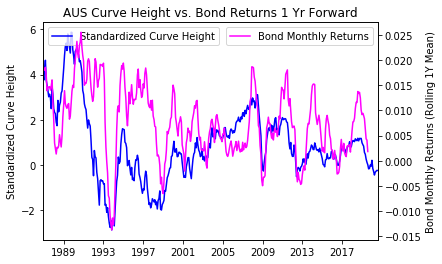

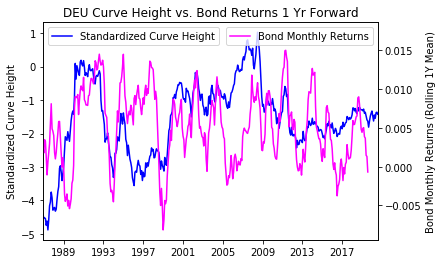

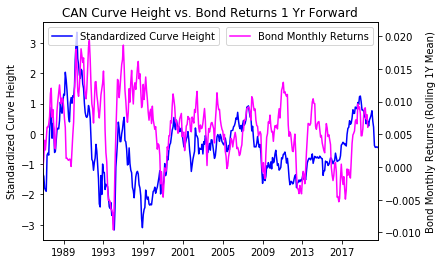

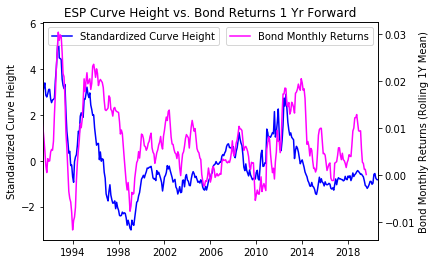

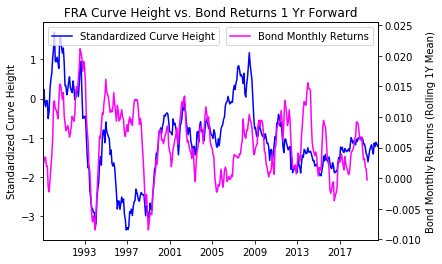

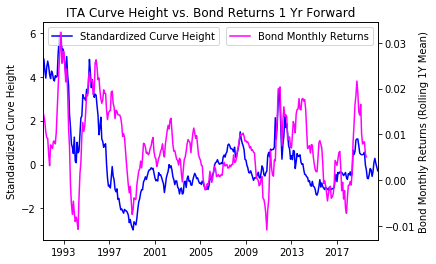

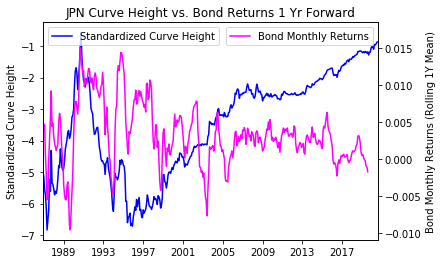

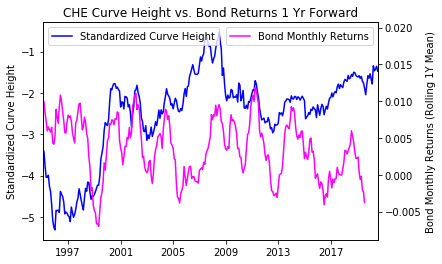

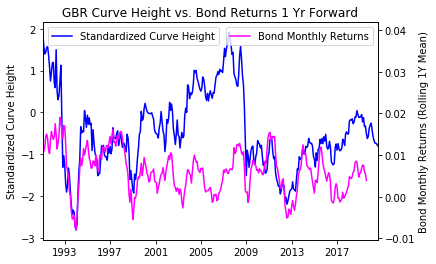

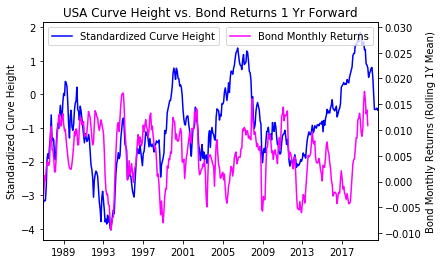

In [487]:
bond_monthly_returns = bond_return_index.resample('M').mean().pct_change()

for country in country_codes:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = 'Standardized Curve Height'
    ax1.plot(relative_CH[country].to_timestamp(), color='blue', 
                 label = ax1_label)
    ax1.set_ylabel(ax1_label)
    ax1.legend(loc=2)
    ax2_label = 'Bond Monthly Returns'
    ax2.plot(bond_monthly_returns[country].shift(-12).to_timestamp()
         .rolling(12).mean(),color='magenta', label = ax2_label)
    ax2.set_ylabel('Bond Monthly Returns (Rolling 1Y Mean)')
    ax2.legend(loc='best')
    
    
    plt.xlim(str(relative_CH[country].dropna().index.min()), 
            str(relative_CH[country].dropna().index.max()))
    plt.title(country + ' Curve Height vs. Bond Returns 1 Yr Forward')
    plt.show()

**explain signals**

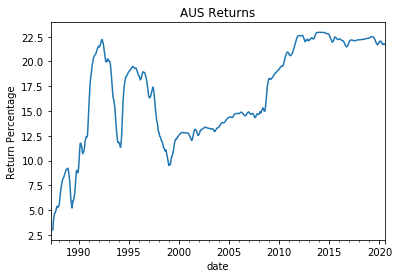

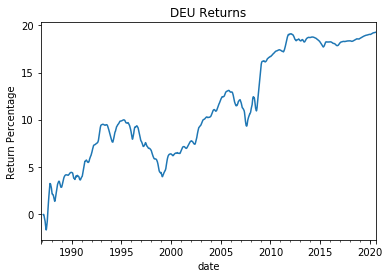

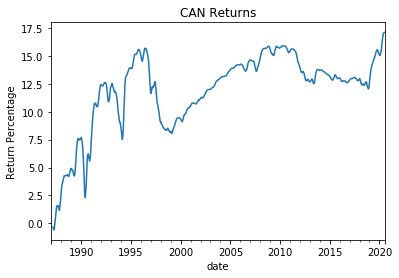

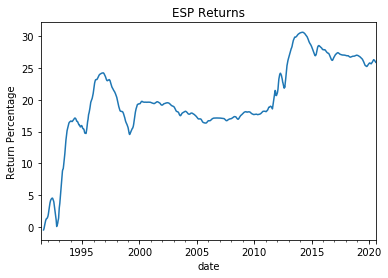

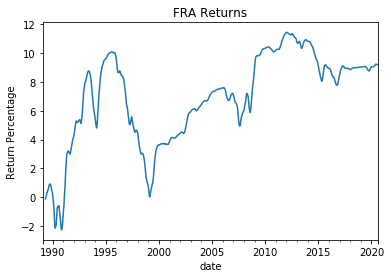

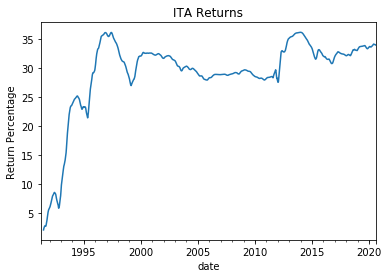

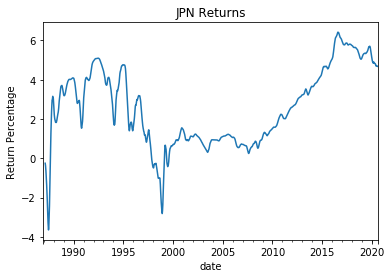

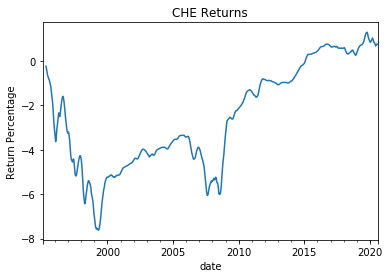

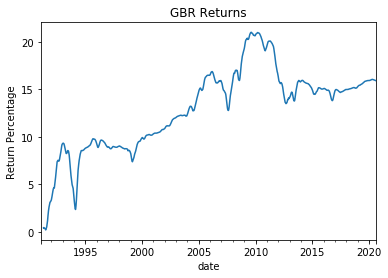

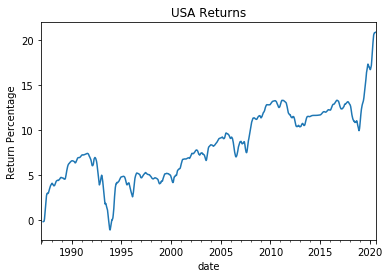

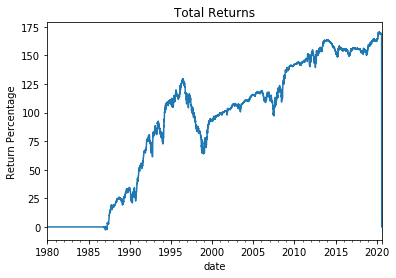

In [413]:
CH_signals = standardized_CH.divide(4).clip(-1,1)
pnl_curve(CH_signals)

In [411]:
sharpe_ratio(CH_signals)

country
AUS        0.307248
DEU        0.397397
CAN        0.250018
ESP        0.355314
FRA        0.194204
ITA        0.451959
JPN        0.106690
CHE        0.031274
GBR        0.325803
USA        0.358508
AVERAGE    0.277841
dtype: float64

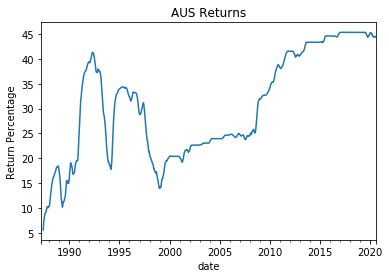

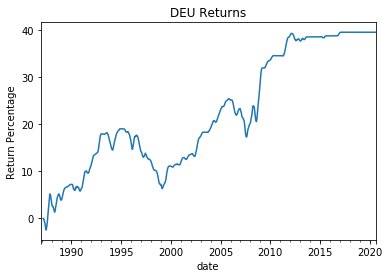

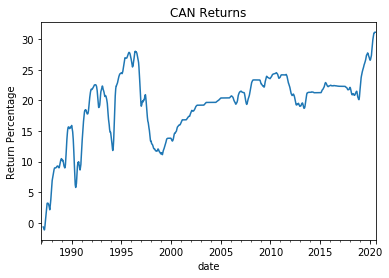

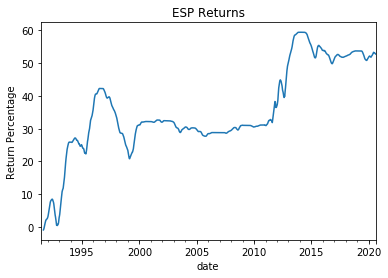

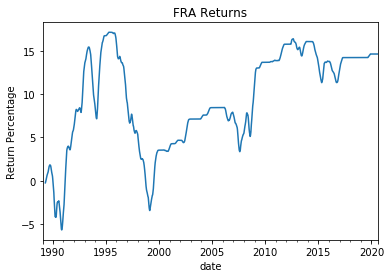

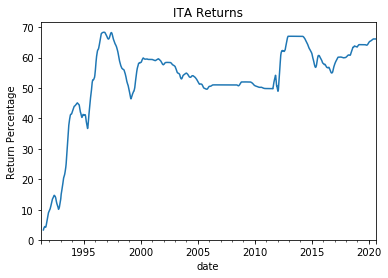

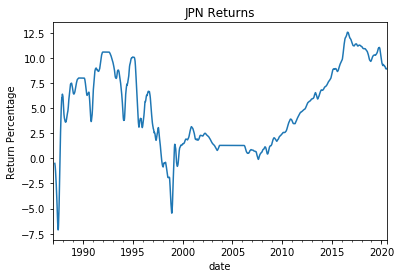

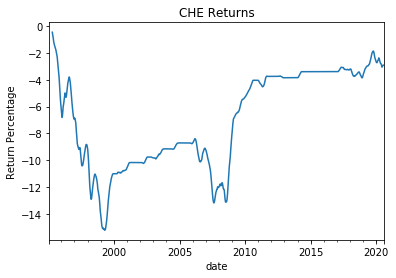

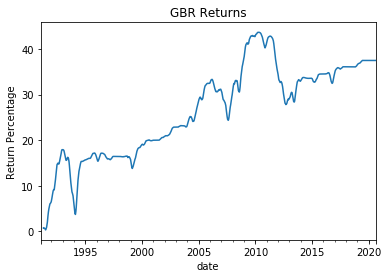

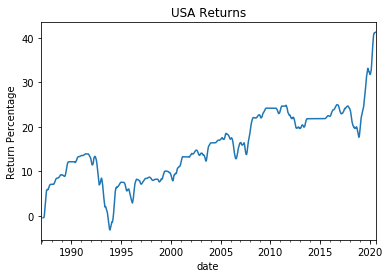

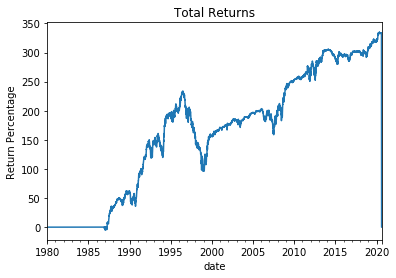

In [573]:
CH_signals = standardized_CH.divide(2).clip(-1,1)
CH_signals[np.abs(CH_signals) < .2] = 0
pnl_curve(CH_signals)

In [574]:
sharpe_ratio(CH_signals)

country
AUS        0.306350
DEU        0.399051
CAN        0.242961
ESP        0.380918
FRA        0.158107
ITA        0.459295
JPN        0.099691
CHE       -0.045870
GBR        0.364776
USA        0.341099
AVERAGE    0.270638
dtype: float64

In [498]:
corr_with_long(CH_signals)

country
AUS       -0.035176
DEU       -0.038170
CAN       -0.007417
ESP        0.294365
FRA        0.007971
ITA        0.334206
JPN       -0.573296
CHE       -0.028332
GBR       -0.164976
USA       -0.135082
AVERAGE   -0.034591
dtype: float64

# Change in GDP

In [40]:
RGDP = dl.pull("GDP/Real")
RGDP_QOQ = RGDP.pct_change()
RGDP_QOQ.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,0.005546,0.003093,0.002792,0.004047,0.001579,0.000052,0.000038,0.004400,0.005116,0.006369
2019Q4,0.005209,-0.000187,0.001397,0.004104,-0.001856,-0.002286,-0.018566,0.003379,-0.000001,0.005862
2020Q1,-0.003060,-0.020186,-0.021089,-0.052090,-0.059396,-0.053805,-0.005586,-0.026071,-0.021872,-0.012627
2020Q2,0.000000,-0.100915,0.000000,-0.184840,-0.138151,-0.123579,0.000000,0.000000,0.000000,-0.094947
2020Q3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [435]:
global_avg_1Y = RGDP_QOQ.rolling(4).mean().mean(axis=1)

# how is it doing relative to the global avg over the past year?
relative_growth = (RGDP_QOQ.sub(global_avg_1Y, axis=0))

# how does that relative performance compare to the country's relative performance
# over the past 7 years (biz cycle)?
standardized_rel_growth = (relative_growth.rolling(28).
                           mean()-relative_growth)/relative_growth.rolling(28).std()

standardized_rel_growth.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,-0.049572,0.039035,0.341381,0.165975,0.460590,0.230537,0.345114,-0.104061,-0.331200,-0.279224
2019Q4,-0.296526,0.595567,0.429977,-0.005488,1.302347,0.914352,2.438509,-0.069151,1.195511,-0.357964
2020Q1,-0.249494,2.739091,2.848431,4.888745,4.907237,4.963611,-0.300591,3.892224,3.962012,2.378498
2020Q2,-4.274271,4.846100,-3.158132,4.875071,4.592448,4.592257,-2.762808,-3.317249,-3.702290,4.944622
2020Q3,-3.304413,-1.600318,-2.718520,-0.856999,-1.196611,-1.413745,-2.468936,-2.806771,-3.056482,-1.557512


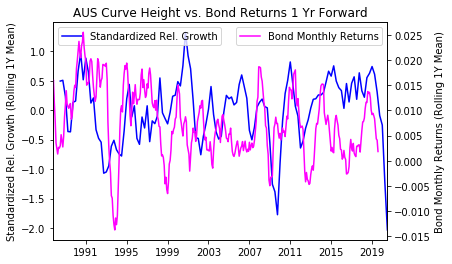

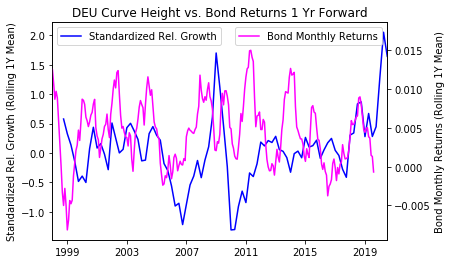

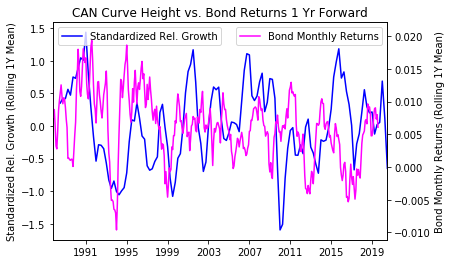

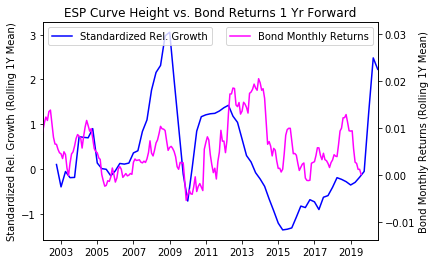

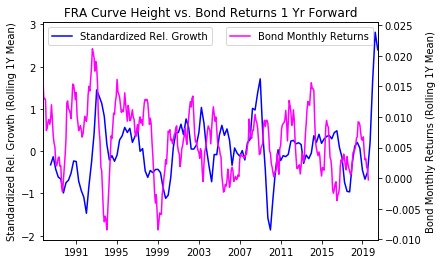

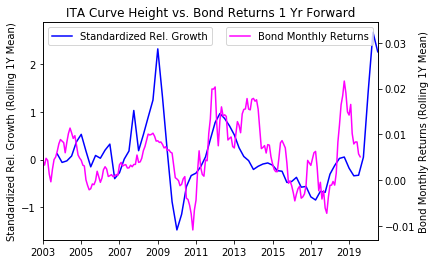

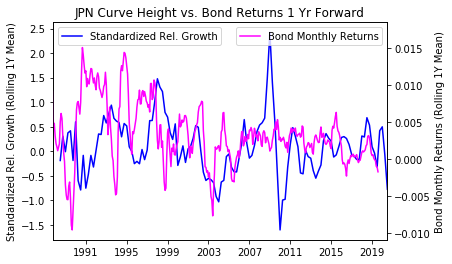

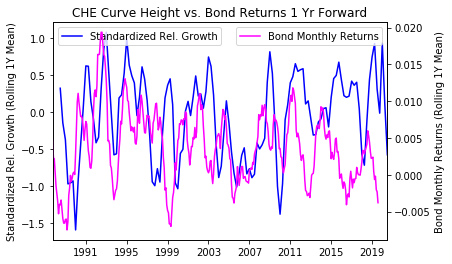

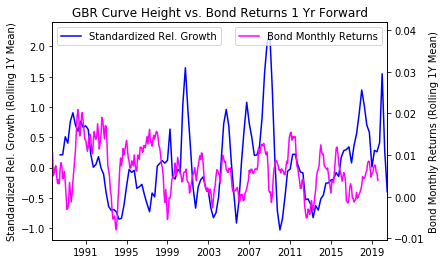

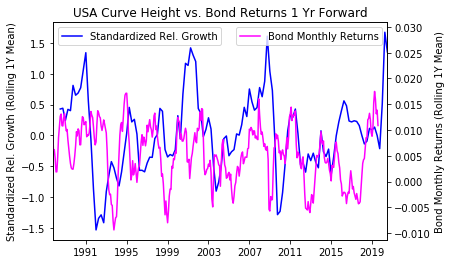

In [486]:
bond_monthly_returns = bond_return_index.resample('M').mean().pct_change()
shifted_monthly_returns = bond_monthly_returns.shift(-12)

for country in country_codes:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = 'Standardized Rel. Growth'
    ax1.plot(standardized_rel_growth[country].rolling(4).mean().dropna()
             .to_timestamp(), color='blue', label = ax1_label)
    ax1.set_ylabel('Standardized Rel. Growth (Rolling 1Y Mean)')
    ax1.legend(loc=2)
    ax2_label = 'Bond Monthly Returns'
    ax2.plot(shifted_monthly_returns[country].to_timestamp()
         .rolling(12).mean(),color='magenta', label = ax2_label)
    ax2.set_ylabel('Bond Monthly Returns (Rolling 1Y Mean)')
    ax2.legend(loc='best')
    
    plt.xlim(str(standardized_rel_growth[country].dropna().index.min()), 
            str(standardized_rel_growth[country].dropna().index.max()))
    plt.title(country + ' Curve Height vs. Bond Returns 1 Yr Forward')
    plt.show()

In [534]:
GDP_signals = standardized_rel_growth.divide(2).clip(-1,1)
GDP_signals.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,-0.024786,0.019517,0.170690,0.082987,0.230295,0.115269,0.172557,-0.052031,-0.165600,-0.139612
2019Q4,-0.148263,0.297783,0.214989,-0.002744,0.651174,0.457176,1.000000,-0.034575,0.597756,-0.178982
2020Q1,-0.124747,1.000000,1.000000,1.000000,1.000000,1.000000,-0.150296,1.000000,1.000000,1.000000
2020Q2,-1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000
2020Q3,-1.000000,-0.800159,-1.000000,-0.428500,-0.598306,-0.706872,-1.000000,-1.000000,-1.000000,-0.778756


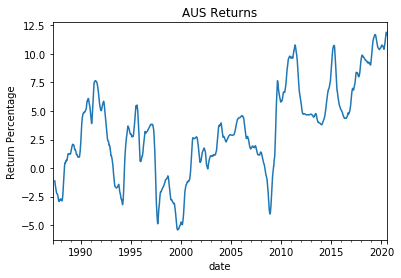

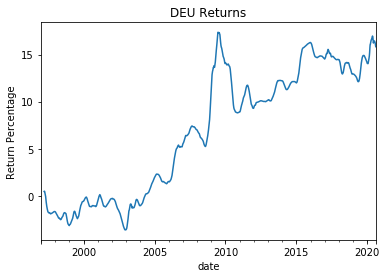

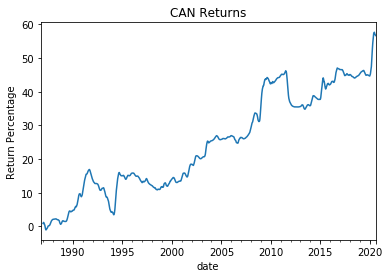

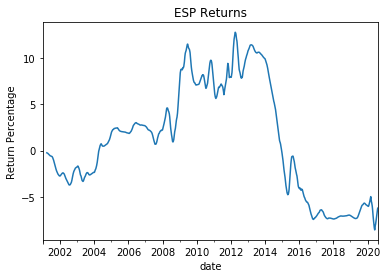

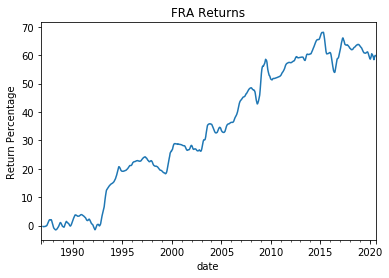

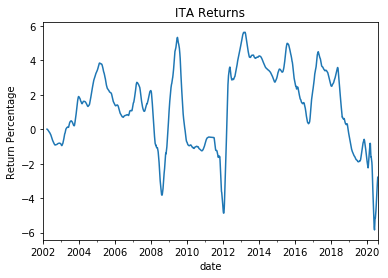

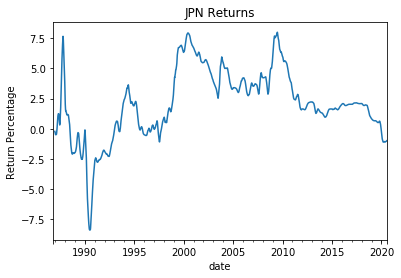

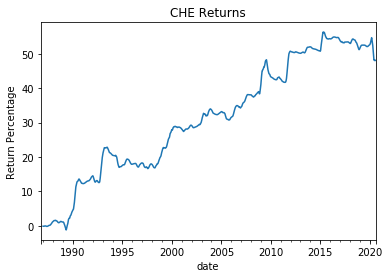

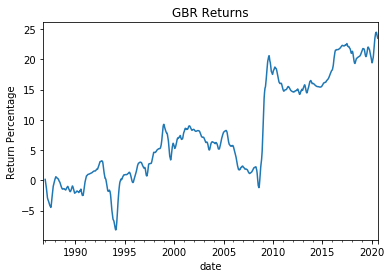

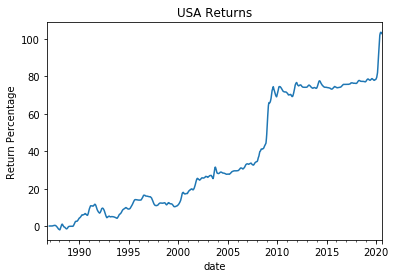

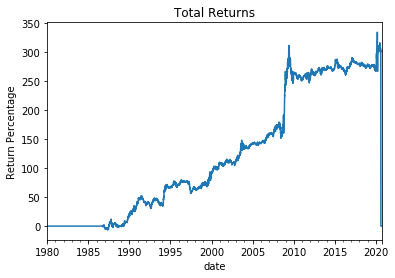

In [262]:
pnl_curve(GDP_signals)

In [537]:
sharpe_ratio(GDP_signals)

country
AUS        0.129945
DEU        0.311384
CAN        0.518856
ESP       -0.006449
FRA        0.453604
ITA        0.092950
JPN       -0.170009
CHE        0.426291
GBR        0.189128
USA        0.516124
AVERAGE    0.246182
dtype: float64

In [538]:
GDP_signals = standardized_rel_growth.divide(2).clip(-1,1)
GDP_signals[np.abs(GDP_signals) < .5] = 0
sharpe_ratio(GDP_signals)

country
AUS        0.129945
DEU        0.311384
CAN        0.518856
ESP       -0.006449
FRA        0.453604
ITA        0.092950
JPN       -0.170009
CHE        0.426291
GBR        0.189128
USA        0.516124
AVERAGE    0.246182
dtype: float64

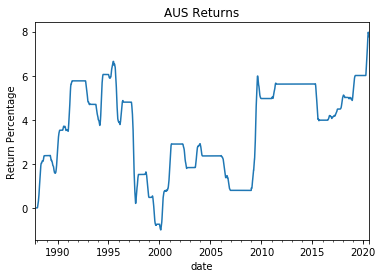

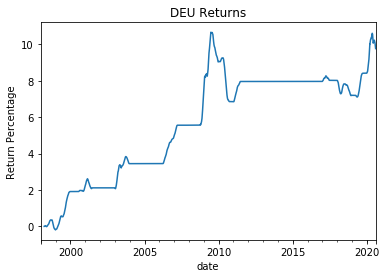

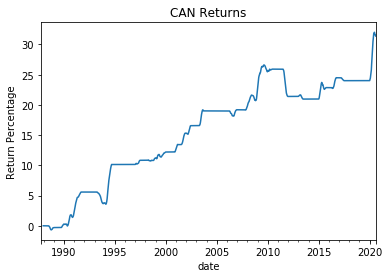

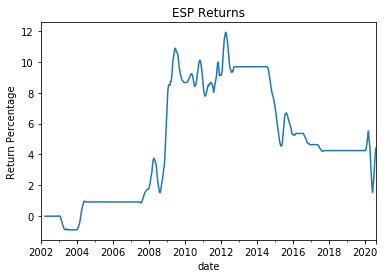

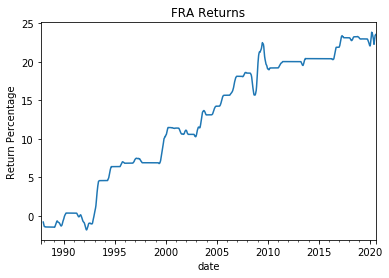

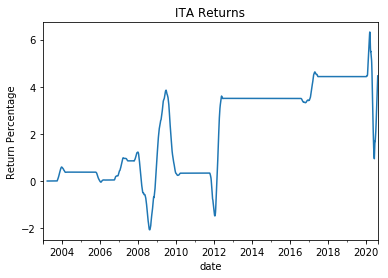

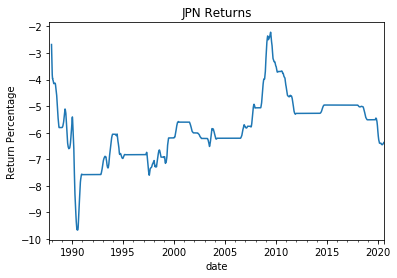

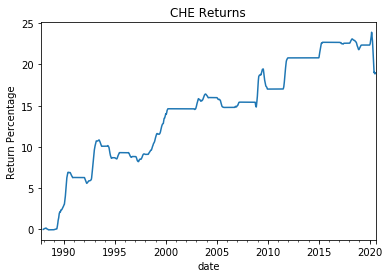

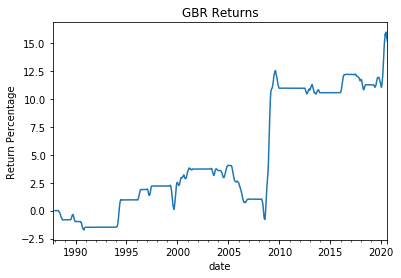

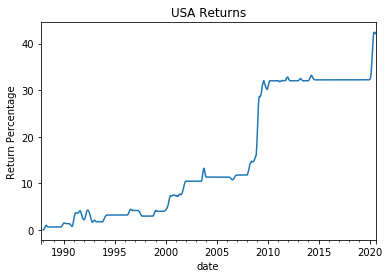

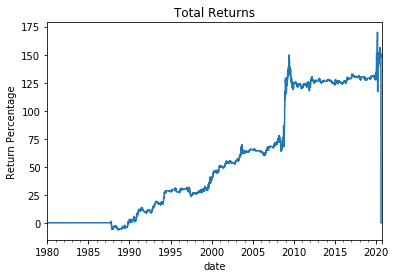

In [516]:
pnl_curve(GDP_signals)

In [517]:
corr_with_long(GDP_signals)

country
AUS       -0.083663
DEU        0.078555
CAN        0.084008
ESP        0.403863
FRA        0.026532
ITA        0.405338
JPN       -0.080643
CHE        0.048872
GBR        0.159694
USA        0.259269
AVERAGE    0.130183
dtype: float64

# Combining Indicators

In [596]:
GDP_signals = GDP_signals.resample("M").ffill()
CH_signals = CH_signals.resample()

bond_monthly_returns = bond_return_index.resample('M').mean().pct_change() - rf_rate_matrix_monthly
lagged_returns = bond_monthly_returns.shift(-1)
    
GDP_returns = lagged_returns * GDP_signals

sig_returns = (lagged_returns * daily_signals)
cum_sig_returns = (1+sig_returns).cumprod()
sig_pct = (cum_sig_returns-1)*100



**Naive Combination**

In [651]:
print(sharpe_ratio(GDP_signals))
print(sharpe_ratio(CH_signals))

country
AUS        0.129945
DEU        0.311384
CAN        0.518856
ESP       -0.006449
FRA        0.453604
ITA        0.092950
JPN       -0.170009
CHE        0.426291
GBR        0.189128
USA        0.516124
AVERAGE    0.246182
dtype: float64
country
AUS        0.306350
DEU        0.399051
CAN        0.242961
ESP        0.380918
FRA        0.158107
ITA        0.459295
JPN        0.099691
CHE       -0.045870
GBR        0.364776
USA        0.341099
AVERAGE    0.270638
dtype: float64


**Smoothing Signals to a 6M Rolling Average**

In [676]:
signals = .5*GDP_signals + .5*CH_signals
signals = signals.rolling(6).mean()
sharpe_ratio(signals)

country
AUS        0.300437
DEU        0.551123
CAN        0.227527
ESP        0.158191
FRA        0.426141
ITA        0.318500
JPN        0.410955
CHE        0.160800
GBR        0.482862
USA        0.305832
AVERAGE    0.334237
dtype: float64

**Amplify Signals that Agree in Direction**

In [680]:
signals = .5*GDP_signals + .5*CH_signals
signals = signals.rolling(6).mean()
signals[GDP_signals*CH_signals > 0] = (signals*2).clip(-1,1)
sharpe_ratio(signals)

country
AUS        0.236258
DEU        0.636217
CAN        0.293715
ESP        0.068005
FRA        0.518394
ITA        0.386747
JPN        0.402641
CHE        0.185526
GBR        0.431183
USA        0.369549
AVERAGE    0.352824
dtype: float64

**Dampen Signals that Disagree in Direction**

In [682]:
signals[GDP_signals*CH_signals < 0] = (signals/2).clip(-1,1)
sharpe_ratio(signals)

country
AUS        0.254892
DEU        0.659372
CAN        0.306043
ESP        0.069617
FRA        0.519523
ITA        0.385529
JPN        0.375360
CHE        0.231094
GBR        0.416908
USA        0.351163
AVERAGE    0.356950
dtype: float64

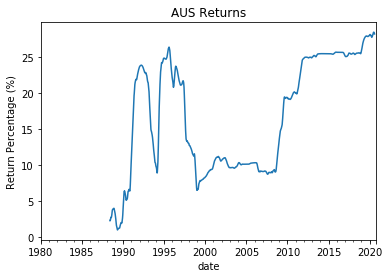

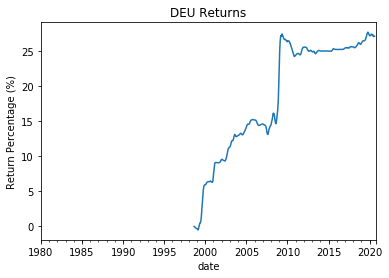

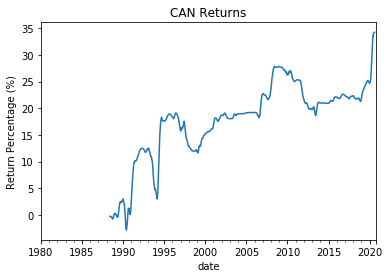

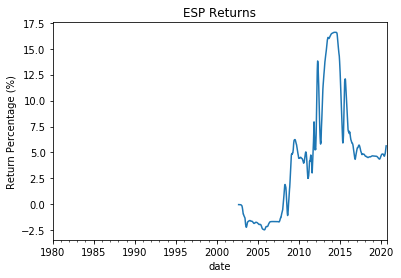

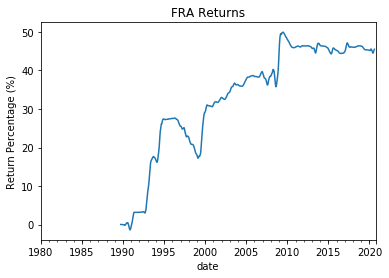

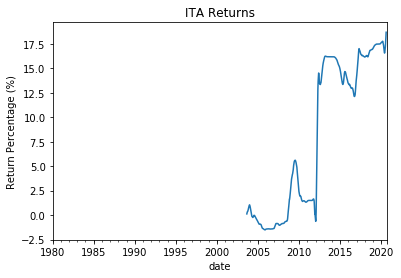

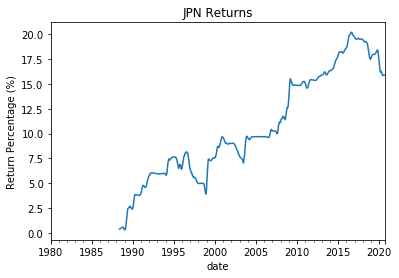

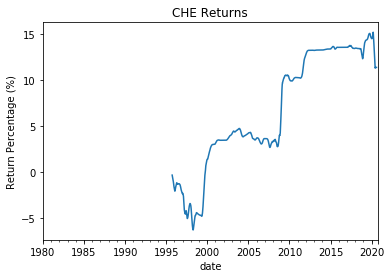

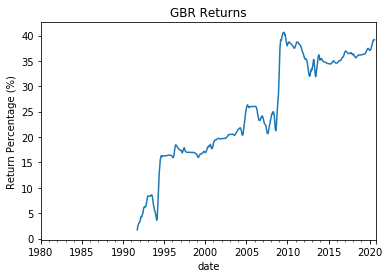

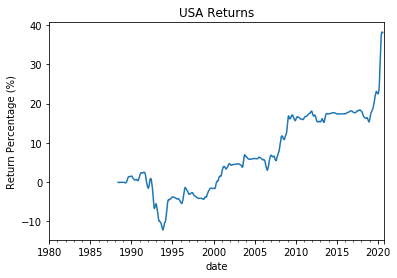

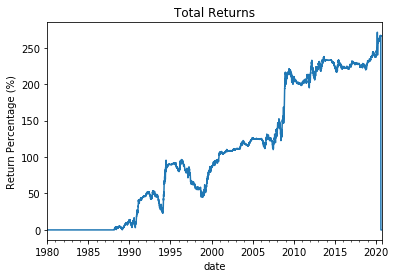

In [684]:
pnl_curve(signals)

In [683]:
corr_with_long(signals)

country
AUS       -0.110244
DEU        0.275188
CAN       -0.033009
ESP        0.325280
FRA        0.016759
ITA        0.304090
JPN       -0.295691
CHE       -0.017366
GBR       -0.030177
USA        0.108356
AVERAGE    0.054319
dtype: float64

In [549]:
signals["ITA"].loc['2011-01':'2013-01']

date
2011-01    0.024964
2011-02    0.005093
2011-03    0.038954
2011-04    0.035069
2011-05    0.037759
2011-06    0.037698
2011-07    0.047710
2011-08    0.173054
2011-09    0.081349
2011-10    0.655597
2011-11    0.845415
2011-12    0.963819
2012-01    0.901367
2012-02    0.636114
2012-03    0.107104
2012-04    0.057947
2012-05    0.094899
2012-06    0.177924
2012-07    0.130964
2012-08    0.146911
2012-09    0.102890
2012-10    0.053226
2012-11    0.039787
2012-12   -0.003856
2013-01    0.011673
Freq: M, Name: ITA, dtype: float64

Italy 2011: signals tell us to go long, but we lose a lot of money

see https://www.nytimes.com/2011/11/08/business/global/italy-bonds-push-higher.html

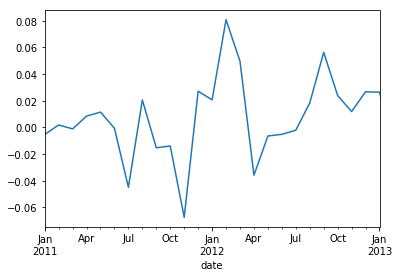

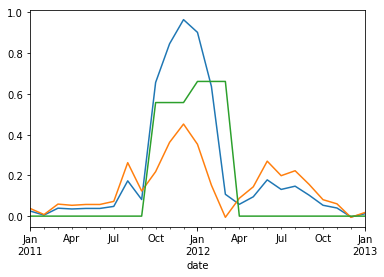

(468, 540)

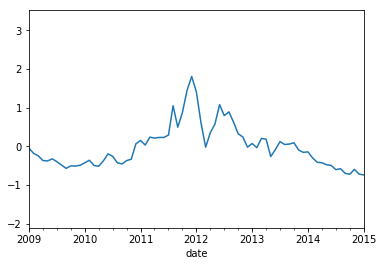

In [570]:
bond_return_index.resample('M').mean().pct_change()['ITA'].plot()
plt.xlim('2011-01','2013-01')
plt.show()
signals["ITA"].loc['2011-01':'2013-01'].plot()
CH_signals["ITA"].loc['2011-01':'2013-01'].plot()
GDP_signals["ITA"].loc['2011-01':'2013-01'].plot()
plt.show()
standardized_CH['ITA'].plot()
plt.xlim('2009-01','2015-01')

In [ ]:
bond_monthly_returns = bond_return_index.resample('M').mean().pct_change() - rf_rate_matrix_monthly
lagged_returns = bond_monthly_returns.shift(-1)
    
sig_returns = (lagged_returns * signals)
cum_sig_returns = (1+sig_returns).cumprod()
sig_pct = (cum_sig_returns-1)*100

for country in country_codes:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(sig_returns[country].rolling(12).mean().dropna()
             .to_timestamp(), color='magenta', label = 'Bond Returns')
    ax1.set_ylabel('Bond Returns')
    ax1.legend(loc=2)
    ax2.plot(signals[country].to_timestamp().rolling(12).mean()
         ,color='crimson', label = 'Trading Signal')
    ax2.set_ylabel('Trading Signal')
    ax2.legend(loc='best')
    plt.title(country + " Returns vs. Signal")